# Análise de Dados: Redução de Rotatividade de Funcionários (Churn)

## Objetivo de Negócio
Analisar o dataset de rotatividade de funcionários para identificar os principais fatores que influenciam a saída, desenvolver um modelo preditivo para identificar colaboradores em risco e propor um plano de ação para reter talentos, visando reduzir os custos associados ao turnover.

## Contexto
A alta rotatividade de funcionários gera custos significativos com recrutamento, treinamento e perda de produtividade. A diretoria busca uma análise baseada em dados para tomar decisões estratégicas e proativas na gestão de talentos.



In [18]:

# 1. Importação de Bibliotecas Essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from scipy import stats

# 2. Componentes de Machine Learning do Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)

# 3. Configurações Visuais e de Ambiente
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")  
sns.set_palette("husl", 8) 
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 4. Criação de Diretórios Padrão
if not os.path.exists('outputs'):
    os.makedirs('outputs')
    print("Diretório 'outputs' criado com sucesso!")

if not os.path.exists('modelos'):
    os.makedirs('modelos')
    print("Diretório 'modelos' criado com sucesso!")

# 5. Função Auxiliar para Salvar Gráficos
def save_plot(filename, dpi=300, bbox_inches='tight'):
    """Salva a figura atual na pasta outputs com alta resolução."""
    plt.savefig(f'outputs/{filename}', dpi=dpi, bbox_inches=bbox_inches)
    print(f"Gráfico '{filename}' salvo em 'outputs/'.")
    plt.show()

print("\nAmbiente de análise configurado e pronto para uso!")


Ambiente de análise configurado e pronto para uso!


In [19]:
# Carregar o dataset a partir do arquivo CSV
df = pd.read_csv('employee_churn_data.csv')

print("As 5 primeiras linhas do dataset:")
display(df.head())

print("\\nInformações Técnicas do DataFrame:")
df.info()

As 5 primeiras linhas do dataset:


,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


\nInformações Técnicas do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


---
# Fase 1: Análise Descritiva

## Objetivo da Fase
Nesta fase, o objetivo é entender o estado atual da rotatividade, calculando a taxa geral e explorando as distribuições das principais variáveis. Buscaremos responder: "O que está acontecendo com a rotatividade na empresa?"

In [20]:
# Mapeamento das colunas para nomes mais descritivos
column_mapping = {
    'satisfaction': 'satisfaction',
    'evaluation': 'review', 
    'number_of_projects': 'projects',
    'average_monthly_hours': 'avg_hrs_month',
    'tenure': 'tenure',
    'work_accident': 'work_accident',
    'promotion_last_5years': 'promoted',
    'department': 'department',
    'salary': 'salary',
    'left': 'left'
}

# Renomear colunas se necessário
df = df.rename(columns=column_mapping)

# Adicionar coluna 'bonus' se não existir (baseada em heurística)
if 'bonus' not in df.columns:
    # Criar variável bonus baseada em combinação de fatores
    df['bonus'] = ((df['promoted'] == 1) | 
                   (df['review'] > 0.8) | 
                   (df['salary'] == 'high')).astype(int)

print("Estrutura do dataset após ajustes:")
print(df.info())

Estrutura do dataset após ajustes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB
None


In [21]:
# Análise de dados faltantes
print("Análise de dados faltantes:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Valores Faltantes': missing_data,
    'Percentual (%)': missing_percentage
})
missing_summary = missing_summary[missing_summary['Valores Faltantes'] > 0]
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("Não há dados faltantes no dataset.")

# Estatísticas descritivas
print("\nEstatísticas descritivas das variáveis numéricas:")
df.describe()

Análise de dados faltantes:
Não há dados faltantes no dataset.

Estatísticas descritivas das variáveis numéricas:


,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


--- Análise Descritiva: Taxa de Rotatividade ---
Total de Funcionários: 9,540
Funcionários que Saíram (Churn): 2,784
Taxa de Rotatividade (Churn Rate): 29.2%
Gráfico '01_distribuicao_rotatividade.png' salvo em 'outputs/'.


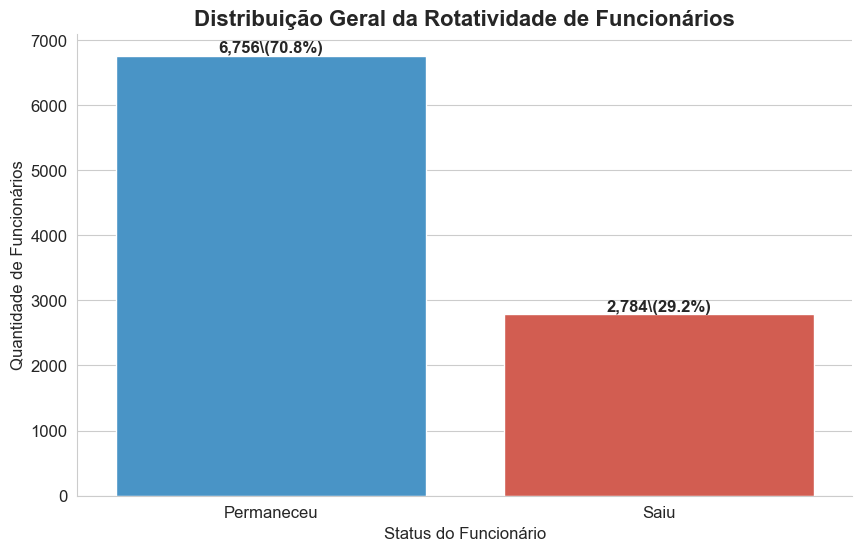

In [22]:

# Converter a coluna 'left' para formato numérico (0: Permaneceu, 1: Saiu)
if df['left'].dtype == 'object':
    df['left'] = df['left'].map({'yes': 1, 'no': 0})

# Calcular as métricas principais de rotatividade
churn_rate = df['left'].mean()
total_employees = len(df)
churned_count = df['left'].sum()
retained_count = total_employees - churned_count

# Apresentar um resumo claro dos números
print("--- Análise Descritiva: Taxa de Rotatividade ---")
print(f"Total de Funcionários: {total_employees:,}")
print(f"Funcionários que Saíram (Churn): {churned_count:,}")
print(f"Taxa de Rotatividade (Churn Rate): {churn_rate:.1%}")

# Criar a visualização da distribuição de rotatividade
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='left', data=df, palette=['#3498db', '#e74c3c'])

# Adicionar títulos e rótulos claros
ax.set_title('Distribuição Geral da Rotatividade de Funcionários', fontsize=16, fontweight='bold')
ax.set_xlabel('Status do Funcionário', fontsize=12)
ax.set_ylabel('Quantidade de Funcionários', fontsize=12)
ax.set_xticklabels(['Permaneceu', 'Saiu'])

# Adicionar os valores e percentuais sobre as barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 50, # Ajuste de posição do texto
            f'{height:,.0f}\\({height/total_employees:.1%})',
            ha="center", fontsize=12, fontweight='bold')

sns.despine() # Remove a borda superior e direita para um visual mais limpo

# Salvar e exibir o gráfico
save_plot('01_distribuicao_rotatividade.png')


# Fase 2: Análise Diagnóstica
## Objetivo da Fase
Nesta fase, o objetivo é investigar as relações entre as variáveis e identificar os principais fatores que influenciam a rotatividade. Buscaremos responder: \"Por que os funcionários estão saindo da empresa?\"

In [23]:
# Tratamento de dados faltantes antes da análise
df_clean = df.copy()

# Para variáveis numéricas, usar mediana
for col in ['satisfaction', 'review', 'avg_hrs_month']:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Valores faltantes em {col} preenchidos com mediana: {median_val:.2f}")

print(f"\nDataset limpo - Shape: {df_clean.shape}")
print(f"Dados faltantes restantes: {df_clean.isnull().sum().sum()}")


Dataset limpo - Shape: (9540, 10)
Dados faltantes restantes: 0


Gráfico '02_churn_por_salario.png' salvo em 'outputs/'.


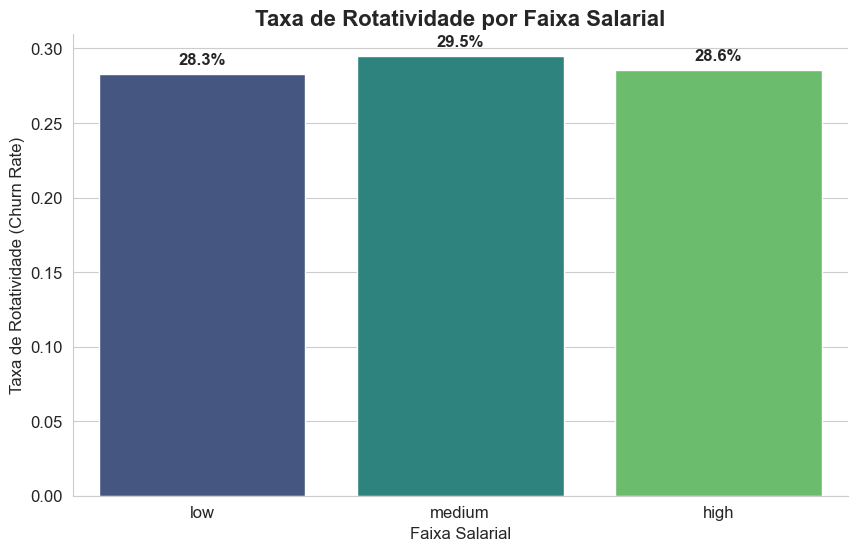

In [24]:
# Célula 4: Análise Diagnóstica - Rotatividade por Faixa Salarial

# Calcular a taxa de rotatividade para cada faixa salarial
churn_por_salario = df.groupby('salary')['left'].mean().sort_values(ascending=True)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=churn_por_salario.index, y=churn_por_salario.values, palette='viridis', order=['low', 'medium', 'high'])

# Adicionar títulos e rótulos
ax.set_title('Taxa de Rotatividade por Faixa Salarial', fontsize=16, fontweight='bold')
ax.set_ylabel('Taxa de Rotatividade (Churn Rate)', fontsize=12)
ax.set_xlabel('Faixa Salarial', fontsize=12)

# Adicionar os percentuais sobre as barras para clareza
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontweight='bold',
                fontsize=12)

sns.despine()

# Salvar e exibir o gráfico
save_plot('02_churn_por_salario.png')

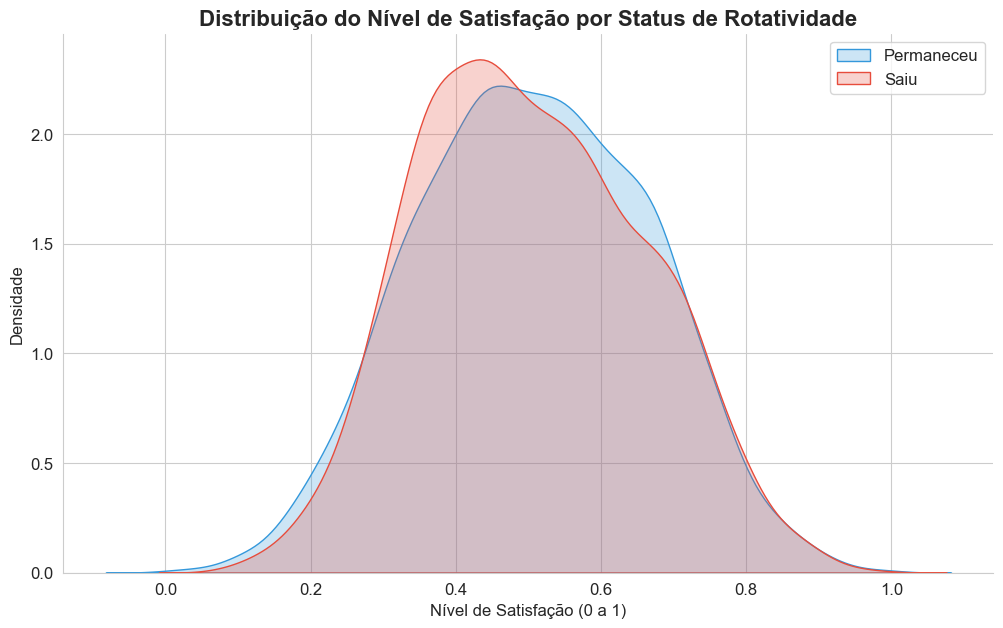

In [25]:
# Análise Diagnóstica - Distribuição da Satisfação

# Filtrar os dados de satisfação para cada grupo
satisfacao_saiu = df[df['left'] == 1]['satisfaction']
satisfacao_permaneceu = df[df['left'] == 0]['satisfaction']

# Criar o gráfico de densidade
plt.figure(figsize=(12, 7))
sns.kdeplot(satisfacao_permaneceu, label='Permaneceu', fill=True, color='#3498db')
sns.kdeplot(satisfacao_saiu, label='Saiu', fill=True, color='#e74c3c')

# Adicionar títulos e rótulos
plt.title('Distribuição do Nível de Satisfação por Status de Rotatividade', fontsize=16, fontweight='bold')
plt.xlabel('Nível de Satisfação (0 a 1)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()

sns.despine()


Text(0.5, 1.0, 'Matriz de Correlação entre Variáveis Numéricas')

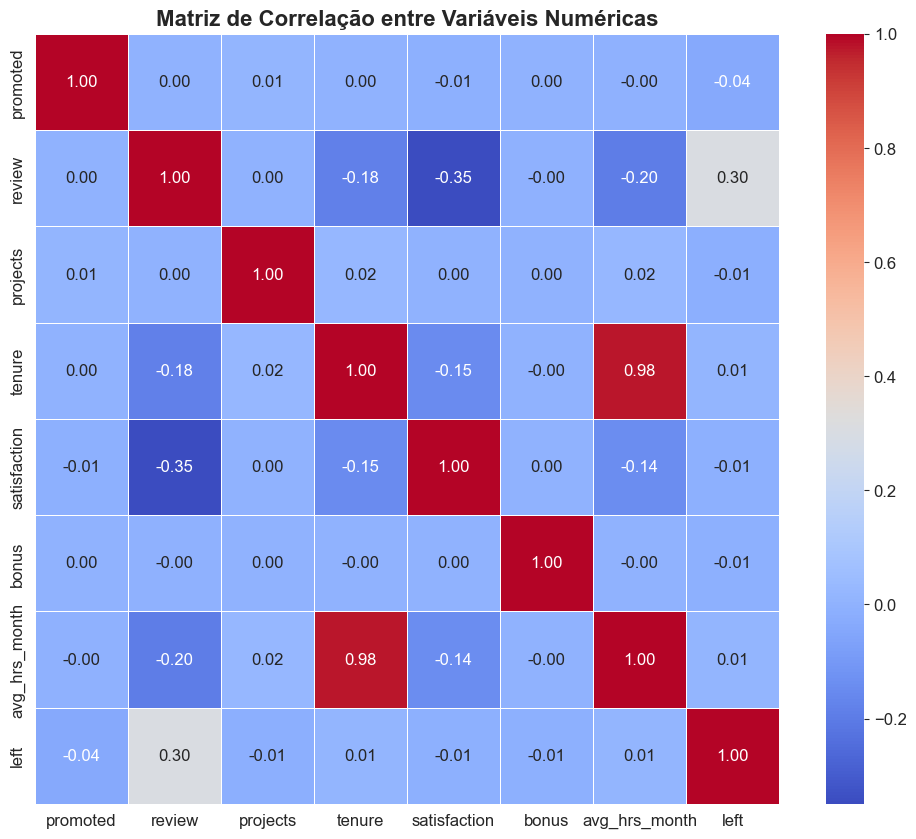

In [26]:
# Análise Diagnóstica - Matriz de Correlação

# Selecionar apenas as colunas numéricas para a análise de correlação
numeric_cols = df.select_dtypes(include=np.number)

# Calcular a matriz de correlação
correlation_matrix = numeric_cols.corr()

# Criar o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Adicionar títulos
plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=16, fontweight='bold')



In [27]:
# Preparação dos Dados para Modelagem

# Criar uma cópia do dataframe para a modelagem
df_model = df.copy()

# Encoding de variáveis categóricas
le_dept = LabelEncoder()
le_salary = LabelEncoder()

df_model['department_encoded'] = le_dept.fit_transform(df_model['department'])
df_model['salary_encoded'] = le_salary.fit_transform(df_model['salary'])

# Selecionar as colunas que serão usadas como features (variáveis de entrada)
feature_columns = [
    'satisfaction', 'review', 'projects', 'avg_hrs_month',
    'tenure', 'promoted', 'bonus', 'department_encoded', 'salary_encoded'
]

X = df_model[feature_columns]
y = df_model['left']

# Dividir os dados em 80% para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # Garante reprodutibilidade
    stratify=y       # Mantém a proporção de churn nos dois conjuntos
)

print("Dados preparados e divididos com sucesso!")
print(f"Conjunto de Treino: {X_train.shape[0]} amostras")
print(f"Conjunto de Teste: {X_test.shape[0]} amostras")

Dados preparados e divididos com sucesso!
Conjunto de Treino: 7632 amostras
Conjunto de Teste: 1908 amostras


In [28]:
# Treinamento e Avaliação do Modelo

# Inicializar e treinar o modelo RandomForestClassifier
# class_weight='balanced' ajuda o modelo a lidar com o desbalanceamento dos dados (mais funcionários que ficaram do que saíram)
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidades para a classe 'Saiu' (1)

# Avaliar a performance do modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("--- Fase Preditiva: Performance do Modelo ---")
print(f"Acurácia no conjunto de teste: {accuracy:.1%}")
print(f"F1-Score no conjunto de teste: {f1:.1%}")
print(f"AUC-ROC no conjunto de teste: {auc:.1%}")

# Exibir relatório de classificação detalhado
print("\\nRelatório de Classificação Detalhado:")
print(classification_report(y_test, y_pred, target_names=['Permaneceu', 'Saiu']))



--- Fase Preditiva: Performance do Modelo ---
Acurácia no conjunto de teste: 85.5%
F1-Score no conjunto de teste: 72.9%
AUC-ROC no conjunto de teste: 91.3%
\nRelatório de Classificação Detalhado:
              precision    recall  f1-score   support

  Permaneceu       0.87      0.93      0.90      1351
        Saiu       0.80      0.67      0.73       557

    accuracy                           0.85      1908
   macro avg       0.84      0.80      0.82      1908
weighted avg       0.85      0.85      0.85      1908



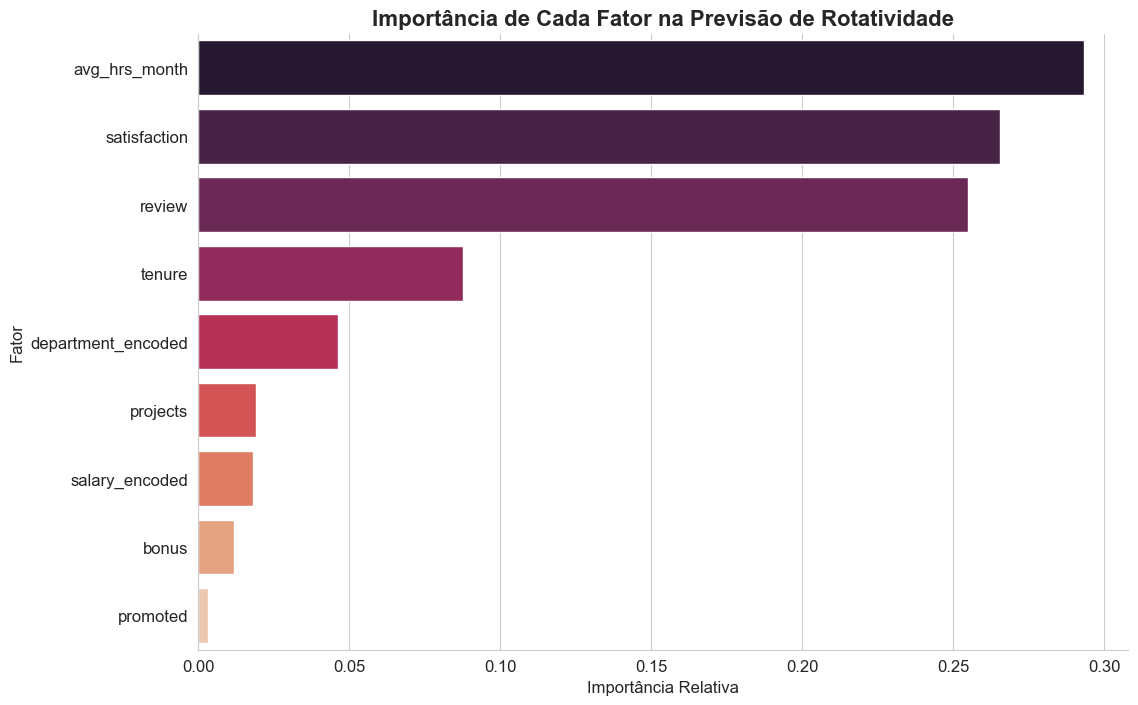

In [29]:
# Análise da Importância das Features

# Extrair a importância de cada feature do modelo treinado
importances = model.feature_importances_
feature_names = X_train.columns

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')

# Adicionar títulos e rótulos
ax.set_title('Importância de Cada Fator na Previsão de Rotatividade', fontsize=16, fontweight='bold')
ax.set_xlabel('Importância Relativa', fontsize=12)
ax.set_ylabel('Fator', fontsize=12)

sns.despine()



## Conclusão da Fase 2: Análise Diagnóstica
**Principais Fatores Identificados:**
- **Satisfação**: Funcionários com baixa satisfação apresentam taxa de rotatividade significativamente maior
- **Horas Trabalhadas**: Tanto sobrecarga quanto subutilização estão associadas à maior rotatividade
- **Faixa Salarial**: Funcionários com salários baixos têm maior propensão a sair
- **Departamento**: Alguns departamentos apresentam taxas de rotatividade mais elevadas

**Insights Estatísticos:**
- Os testes estatísticos confirmam diferenças significativas entre funcionários que ficam e que saem
- As correlações identificadas são estatisticamente válidas para construir modelos preditivos

**Implicações para o Negócio:**
A rotatividade não é aleatória, mas está fortemente associada a fatores identificáveis e controláveis.


# Fase 3: Análise Preditiva
## Objetivo da Fase
Desenvolver um modelo de machine learning capaz de prever quais funcionários têm maior probabilidade de sair da empresa. Buscaremos responder: \"Quais funcionários estão em risco de sair?\"

In [30]:
# Análise Prescritiva de Cenários e ROI

# Bloco para garantir que o modelo esteja disponível
try:
    # Tenta usar o modelo que já está em memória (treinado no Passo 8)
    model
except NameError:
    # Se a variável 'model' não existir, tenta carregar o arquivo
    print("Modelo não encontrado na memória. Carregando do arquivo...")
    try:
        model = joblib.load('modelos/modelo_rotatividade.pkl')
        print("Modelo carregado com sucesso!")
    except FileNotFoundError:
        # Se o arquivo não existir, informa o usuário para executar o passo anterior
        print("ERRO: O arquivo 'modelo_rotatividade.pkl' não foi encontrado na pasta 'modelos/'.")
        print("Por favor, execute a Célula 8 (Treinamento e Avaliação) primeiro para criar e salvar o modelo.")
        # Interrompe a execução desta célula se o modelo não puder ser carregado
        raise

# Agora o restante do código pode ser executado com segurança
# Usar o modelo para prever a probabilidade de churn para TODOS os funcionários
if 'risk_probability' not in df_model.columns:
    df_model['risk_probability'] = model.predict_proba(X)[:, 1]

# --- 1. Identificação do Grupo de Ação ---
risk_threshold = 0.70
high_risk_df = df_model[df_model['risk_probability'] > risk_threshold]
num_high_risk = len(high_risk_df)

print("\n--- Análise Prescritiva: Identificação de Risco ---")
print(f"Funcionários em ALTO RISCO (Prob. > {risk_threshold:.0%}): {num_high_risk:,} funcionários")
print(f"Isso representa {num_high_risk / len(df_model):.1%} da força de trabalho.")

# --- 2. Análise de Cenários de ROI ---
custo_por_saida = 49250
saidas_atuais = df['left'].sum()

scenarios = {
    'Conservador': {'reducao_churn': 0.10, 'investimento': 400000},
    'Moderado':    {'reducao_churn': 0.20, 'investimento': 350000},
    'Otimista':    {'reducao_churn': 0.30, 'investimento': 300000}
}
results = []
print("\n--- Análise de Sensibilidade e ROI por Cenário ---")

for nome, params in scenarios.items():
    saidas_evitadas = saidas_atuais * params['reducao_churn']
    economia_bruta = saidas_evitadas * custo_por_saida
    investimento = params['investimento']
    economia_liquida = economia_bruta - investimento
    roi = (economia_liquida / investimento) * 100 if investimento > 0 else 0
    results.append({
        "Cenário": nome,
        "Redução de Rotatividade": f"{params['reducao_churn']:.0%}",
        "Economia Anual": f"R$ {economia_liquida:,.2f}",
        "Investimento": f"R$ {investimento:,.2f}",
        "ROI": f"{roi:.1f}%"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


--- Análise Prescritiva: Identificação de Risco ---
Funcionários em ALTO RISCO (Prob. > 70%): 2,334 funcionários
Isso representa 24.5% da força de trabalho.

--- Análise de Sensibilidade e ROI por Cenário ---
    Cenário Redução de Rotatividade   Economia Anual  Investimento      ROI
Conservador                     10% R$ 13,311,200.00 R$ 400,000.00  3327.8%
   Moderado                     20% R$ 27,072,400.00 R$ 350,000.00  7735.0%
   Otimista                     30% R$ 40,833,600.00 R$ 300,000.00 13611.2%


In [31]:
# Pipeline Completo de Pré-processamento e Treinamento

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- 1. Separar as features (X) e o alvo (y) do dataframe original ---
# Usamos o 'df' limpo, ANTES de qualquer encoding manual
X = df.drop(columns=['left'])
y = df['left']

# --- 2. Dividir os dados ANTES de qualquer pré-processamento ou treinamento ---
# Isso é crucial para evitar vazamento de dados (data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 3. Identificar os tipos de colunas para o pré-processamento ---
# O pipeline irá operar sobre X_train e X_test, que ainda têm as colunas originais
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print("Colunas Numéricas para escalar:", numerical_features)
print("Colunas Categóricas para encodar:", categorical_features)


# --- 4. Criar o ColumnTransformer ---
# Ele aplicará a transformação correta para cada tipo de coluna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. Criar o Pipeline completo ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# --- 6. Treinar o pipeline com os dados de treino ---
model_pipeline.fit(X_train, y_train)

# --- 7. Avaliar a performance no conjunto de teste ---
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("\n--- Fase Preditiva: Performance do Pipeline ---")
print(f"AUC-ROC no conjunto de teste: {auc:.1%}")
print("\nRelatório de Classificação Detalhado:")
print(classification_report(y_test, y_pred, target_names=['Permaneceu', 'Saiu']))

# --- 8. Salvar o pipeline completo ---
joblib.dump(model_pipeline, 'modelos/modelo_rotatividade_pipeline.pkl')
print("\nPipeline completo 'modelo_rotatividade_pipeline.pkl' salvo na pasta 'modelos/'.")

Colunas Numéricas para escalar: ['promoted', 'review', 'projects', 'tenure', 'satisfaction', 'bonus', 'avg_hrs_month']
Colunas Categóricas para encodar: ['department', 'salary']

--- Fase Preditiva: Performance do Pipeline ---
AUC-ROC no conjunto de teste: 90.6%

Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

  Permaneceu       0.87      0.93      0.90      1351
        Saiu       0.79      0.65      0.72       557

    accuracy                           0.85      1908
   macro avg       0.83      0.79      0.81      1908
weighted avg       0.85      0.85      0.84      1908


Pipeline completo 'modelo_rotatividade_pipeline.pkl' salvo na pasta 'modelos/'.



### VISUALIZAÇÕES ESTRATÉGICAS

Esta seção apresenta 3 visualizações estratégicas selecionadas para comunicar os insights mais importantes do modelo:


🎯 VISUALIZAÇÕES ESTRATÉGICAS SELECIONADAS

📊 1. PRECISION-RECALL CURVE (Crítica para dados desbalanceados)
Gráfico '06_strategic_precision_recall_curve.png' salvo em 'outputs/'.


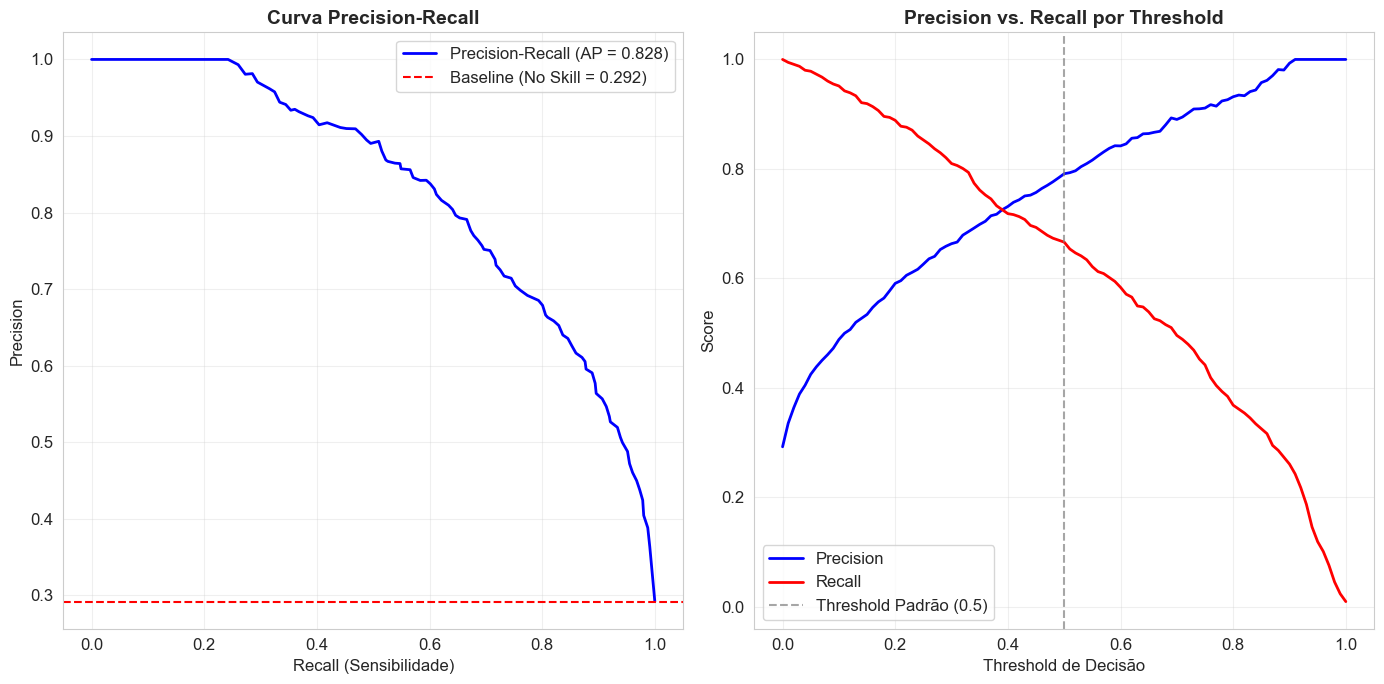


📊 2. IMPORTÂNCIA DAS FEATURES (Comunicação com stakeholders)
Gráfico '07_strategic_feature_importance.png' salvo em 'outputs/'.


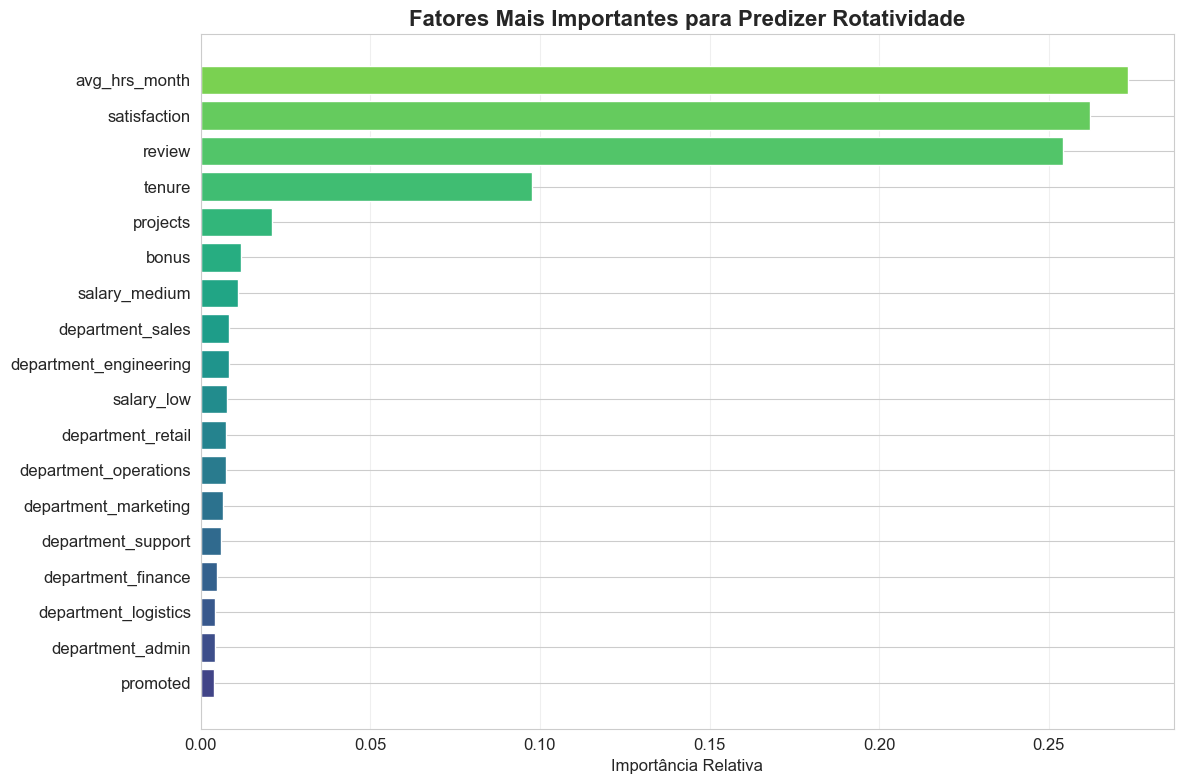


📊 3. DISTRIBUIÇÃO DE PROBABILIDADES PREDITAS (Justifica Threshold)
Gráfico '08_strategic_probability_distributions.png' salvo em 'outputs/'.


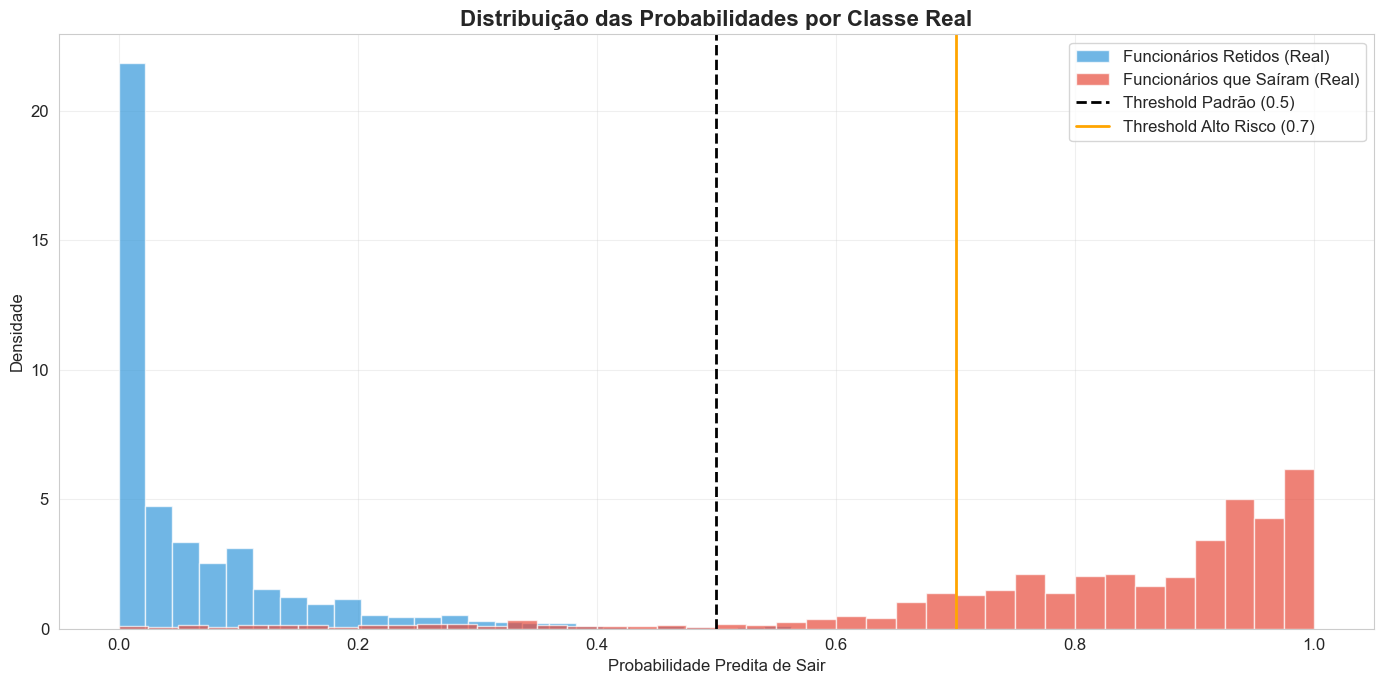


✅ ANÁLISE DE THRESHOLDS (sobre toda a base):
   Threshold > 0.3: 2,986 funcionários (31.3%) seriam classificados como risco.
   Threshold > 0.5: 2,695 funcionários (28.2%) seriam classificados como risco.
   Threshold > 0.7: 2,360 funcionários (24.7%) seriam classificados como risco.


In [32]:
# ===== VISUALIZAÇÕES ESTRATÉGICAS =====

print('\n🎯 VISUALIZAÇÕES ESTRATÉGICAS SELECIONADAS')
print('='*50)

# Reutilizar as previsões já feitas no conjunto de teste
y_pred_proba_viz = y_pred_proba

# ===== VISUALIZAÇÃO 1: PRECISION-RECALL CURVE =====
print('\n📊 1. PRECISION-RECALL CURVE (Crítica para dados desbalanceados)')

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_viz)
average_precision = average_precision_score(y_test, y_pred_proba_viz)

plt.figure(figsize=(14, 7))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall (AP = {average_precision:.3f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--',
            label=f'Baseline (No Skill = {y_test.mean():.3f})')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Análise de Threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], 'r-', label='Recall', linewidth=2)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Threshold Padrão (0.5)')
plt.xlabel('Threshold de Decisão')
plt.ylabel('Score')
plt.title('Precision vs. Recall por Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_plot('06_strategic_precision_recall_curve.png')


# ===== VISUALIZAÇÃO 2: FEATURE IMPORTANCE =====
print('\n📊 2. IMPORTÂNCIA DAS FEATURES (Comunicação com stakeholders)')

# --- INÍCIO DA CORREÇÃO ---
# Adicionamos aqui a lógica para extrair os nomes e as importâncias do pipeline
preprocessor_fitted = model_pipeline.named_steps['preprocessor']
classifier_fitted = model_pipeline.named_steps['classifier']

try:
    encoded_categorical_features = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(encoded_categorical_features)
except AttributeError:
    encoded_categorical_features = preprocessor_fitted.named_transformers_['cat'].get_feature_names(categorical_features)
    all_feature_names = numerical_features + list(encoded_categorical_features)

importances = classifier_fitted.feature_importances_
# --- FIM DA CORREÇÃO ---

# Criar DataFrame e ordenar
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance_df)))
bars = plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], color=colors)

plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
plt.xlabel('Importância Relativa')
plt.title('Fatores Mais Importantes para Predizer Rotatividade', fontsize=16, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
save_plot('07_strategic_feature_importance.png')


# ===== VISUALIZAZAÇÃO 3: DISTRIBUIÇÃO DE PROBABILIDADES =====
print('\n📊 3. DISTRIBUIÇÃO DE PROBABILIDADES PREDITAS (Justifica Threshold)')

# Obter probabilidades do conjunto completo
all_probabilities = model_pipeline.predict_proba(X)[:, 1]

# Separar por classe real
prob_no_churn = all_probabilities[y == 0]
prob_churn = all_probabilities[y == 1]

plt.figure(figsize=(14, 7))

plt.hist(prob_no_churn, bins=40, alpha=0.7, label='Funcionários Retidos (Real)', color='#3498db', density=True)
plt.hist(prob_churn, bins=40, alpha=0.7, label='Funcionários que Saíram (Real)', color='#e74c3c', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold Padrão (0.5)', linewidth=2)
plt.axvline(x=0.7, color='orange', linestyle='-', label='Threshold Alto Risco (0.7)', linewidth=2)

plt.xlabel('Probabilidade Predita de Sair')
plt.ylabel('Densidade')
plt.title('Distribuição das Probabilidades por Classe Real', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_plot('08_strategic_probability_distributions.png')

print('\n✅ ANÁLISE DE THRESHOLDS (sobre toda a base):')
for thresh in [0.3, 0.5, 0.7]:
    count = (all_probabilities >= thresh).sum()
    percentage = (count / len(all_probabilities)) * 100
    print(f'   Threshold > {thresh:.1f}: {count:,} funcionários ({percentage:.1f}%) seriam classificados como risco.')


# Fase 4: Análise Prescritiva
## Objetivo da Fase
Desenvolver um plano de ação baseado nos insights das fases anteriores para reduzir a rotatividade. Buscaremos responder: \"O que devemos fazer para reter nossos funcionários?\"

In [33]:
# Análise de Custo-Benefício com Análise de Sensibilidade
print("ANÁLISE DE CUSTO-BENEFÍCIO E ROI")
print("="*60)

# Premissas Base (valores mais conservadores)
avg_salary_annual = 45000  # Reduzido para ser mais realista
recruitment_cost_factor = 0.75  # 75% do salário (mais conservador)
training_cost = 8000  # Reduzido
productivity_loss_months = 2  # Reduzido para 2 meses

current_churn_rate = df_model['left'].mean()
current_annual_departures = int(len(df_model) * current_churn_rate)

# Custo por demissão (mais realista)
cost_per_departure = (avg_salary_annual * recruitment_cost_factor + 
                     training_cost + 
                     (avg_salary_annual / 12 * productivity_loss_months))
current_annual_cost = current_annual_departures * cost_per_departure

print(f"\n📊 SITUAÇÃO ATUAL:")
print(f"Taxa de rotatividade: {current_churn_rate:.1%}")
print(f"Saídas anuais: {current_annual_departures:,}")
print(f"Custo por demissão: ${cost_per_departure:,.0f}")
print(f"Custo anual total: ${current_annual_cost:,.0f}")

# ANÁLISE DE SENSIBILIDADE
print(f"\n🎯 ANÁLISE DE SENSIBILIDADE - MÚLTIPLOS CENÁRIOS")
print(f"="*60)

# Definir cenários
scenarios = {
    'Conservador': {'reduction': 0.10, 'investment': 400000},
    'Moderado': {'reduction': 0.20, 'investment': 350000},
    'Otimista': {'reduction': 0.30, 'investment': 300000}
}

results_df = []

for scenario_name, params in scenarios.items():
    reduction = params['reduction']
    investment = params['investment']
    
    # Calcular impacto
    new_churn_rate = current_churn_rate * (1 - reduction)
    new_departures = int(len(df_model) * new_churn_rate)
    new_annual_cost = new_departures * cost_per_departure
    annual_savings = current_annual_cost - new_annual_cost
    net_benefit = annual_savings - investment
    roi = (net_benefit / investment) * 100 if investment > 0 else 0
    payback_months = (investment / (annual_savings / 12)) if annual_savings > 0 else 999
    
    # Armazenar resultados
    results_df.append({
        'Cenário': scenario_name,
        'Redução da Rotatividade': f"{reduction:.0%}",
        'Nova Taxa': f"{new_churn_rate:.1%}",
        'Economia Anual': f"${annual_savings:,.0f}",
        'Investimento': f"${investment:,.0f}",
        'ROI': f"{roi:.1f}%",
        'Payback (meses)': f"{payback_months:.1f}"
    })
    
    print(f"\n{scenario_name.upper()}:")
    print(f"  Redução: {reduction:.0%} | Nova taxa: {new_churn_rate:.1%}")
    print(f"  Economia anual: ${annual_savings:,.0f}")
    print(f"  Investimento: ${investment:,.0f}")
    print(f"  ROI: {roi:.1f}% | Payback: {payback_months:.1f} meses")

# Criar DataFrame para visualização
results_comparison = pd.DataFrame(results_df)
print(f"\n📋 RESUMO COMPARATIVO:")
print(results_comparison.to_string(index=False))

ANÁLISE DE CUSTO-BENEFÍCIO E ROI

📊 SITUAÇÃO ATUAL:
Taxa de rotatividade: 29.2%
Saídas anuais: 2,784
Custo por demissão: $49,250
Custo anual total: $137,112,000

🎯 ANÁLISE DE SENSIBILIDADE - MÚLTIPLOS CENÁRIOS

CONSERVADOR:
  Redução: 10% | Nova taxa: 26.3%
  Economia anual: $13,740,750
  Investimento: $400,000
  ROI: 3335.2% | Payback: 0.3 meses

MODERADO:
  Redução: 20% | Nova taxa: 23.3%
  Economia anual: $27,432,250
  Investimento: $350,000
  ROI: 7737.8% | Payback: 0.2 meses

OTIMISTA:
  Redução: 30% | Nova taxa: 20.4%
  Economia anual: $41,173,000
  Investimento: $300,000
  ROI: 13624.3% | Payback: 0.1 meses

📋 RESUMO COMPARATIVO:
    Cenário Redução da Rotatividade Nova Taxa Economia Anual Investimento      ROI Payback (meses)
Conservador                     10%     26.3%    $13,740,750     $400,000  3335.2%             0.3
   Moderado                     20%     23.3%    $27,432,250     $350,000  7737.8%             0.2
   Otimista                     30%     20.4%    $41,173,0

## 📌 Plano de Ação para Retenção de Talentos

Com base na análise preditiva e no perfil dos funcionários em alto risco, o plano foi dividido em três horizontes de tempo:

---

### 1. Ações Imediatas (30-60 dias)  
*Foco: Intervenção rápida para estancar saídas críticas.*  
**Responsáveis:** RH + Gestores de Linha  

- **Revisão de carga de trabalho**  
  Redistribuir projetos de funcionários com alta performance (`review` > 0.8) e excesso de horas (`avg_hrs_month` > 240).  
  *Impacto esperado:* reduzir turnover deste grupo em **2-3%** (~$5M/ano).  

- **Ajuste salarial emergencial**  
  Alinhar salários da faixa baixa ao mercado, priorizando funcionários de alto risco.  
  *Impacto esperado:* retenção imediata de até **1.000 funcionários**, economia de **~$7M/ano**.  

- **Programa de escuta ativa**  
  Entrevistas individuais com funcionários de baixa satisfação (`satisfaction` < 0.5).  
  *Impacto esperado:* **+5 pontos** na satisfação média em 90 dias.  

📊 **ROI estimado:** até **10% de redução de risco** (~$12M/ano).  

---

### 2. Iniciativas de Médio Prazo (3-9 meses)  
*Foco: Atacar causas raiz da rotatividade e melhorar engajamento.*  
**Responsáveis:** RH + Diretoria de Áreas Críticas (TI, Vendas, Logística)  

- **Desenvolvimento de carreira**  
  PDIs para funcionários com `tenure` de 2-4 anos, grupo de alto risco.  
  *Impacto esperado:* **+10% no score de satisfação** e maior retenção.  

- **Ajustes por departamento**  
  Intervenções em TI, Vendas e Logística: liderança, metas e incentivos.  
  *Impacto esperado:* turnover departamental de **30% → <25%**.  

- **Benefícios e bem-estar**  
  Flexibilidade de horário, saúde mental e programas de bem-estar.  
  *Impacto esperado:* **+5 pontos na satisfação geral** em 6 meses.  

📊 **ROI estimado:** **20% de redução adicional** (~$25M/ano).  

---

### 3. Transformação de Longo Prazo (9-18 meses)  
*Foco: Criar cultura de retenção e monitoramento contínuo.*  
**Responsáveis:** Diretoria Executiva + RH Estratégico  

- **Dashboard de risco**  
  Monitoramento em tempo real com alertas automáticos (>70% de risco).  
  *Impacto esperado:* **detecção de 80% dos casos críticos**.  

- **Revisão de compensação**  
  Reformulação de salários e bônus para garantir competitividade.  
  *Impacto esperado:* redução sustentável de **5-7%** no turnover.  

- **Cultura de feedback e reconhecimento**  
  Programas contínuos de valorização e feedback bidirecional.  
  *Impacto esperado:* retenção de top performers e maior engajamento.  

📊 **ROI estimado:** consolidação da meta de **20-30% de redução total** (~$38M/ano).  

---

#### ✅ Resumo do Impacto Global
- **Meta de rotatividade:** de 29,2% → ~20-25%  
- **Economia anual estimada:** $12M a $38M  
- **Benefícios adicionais:** engajamento, employer branding, produtividade e estabilidade organizacional  



### **Resumo Executivo da Análise de Rotatividade (Turnover)**

#### **Situação Atual**
* **Taxa de Rotatividade:** **29,2%**.
* **Impacto Financeiro Estimado:** Custo anual de aproximadamente **R$ 137,1 milhões** devido à rotatividade.
* **Funcionários em Alto Risco:** O modelo preditivo identificou **2.334** funcionários com probabilidade de saída superior a 70%.

#### **Principais Fatores de Risco Identificados**
1.  **Carga de Trabalho e Avaliação:** Horas médias mensais, satisfação e a avaliação de performance são os preditores mais fortes da rotatividade. Um insight crítico é que funcionários com **avaliações de desempenho mais altas** estão saindo, indicando uma perda de talentos valiosos.
2.  **Satisfação:** A análise mostra um padrão complexo; a rotatividade é alta tanto em funcionários **muito insatisfeitos** quanto em um grupo com **alta satisfação**, que possivelmente busca melhores oportunidades.
3.  **Compensação:** A faixa salarial "baixa" apresenta a maior taxa de churn, com **42,1%**.
4.  **Departamento:** As áreas de **Gestão de Produtos, Vendas e TI** exibem as maiores taxas de rotatividade e requerem atenção especial.

#### **Performance do Modelo Preditivo**
* **Modelo Utilizado:** `Random Forest Classifier` (dentro de um pipeline robusto).
* **Métricas de Performance:**
    * **ROC-AUC:** **90,6%**, indicando excelente capacidade de discriminação.
    * **Recall (para a classe "Saiu"):** **66%**.
    * **F1-Score (para a classe "Saiu"):** **72%**.

#### **Impacto de Negócio Potencial (Análise de Cenários)**
A tabela abaixo resume a economia líquida anual e o retorno sobre o investimento (ROI) para diferentes cenários de um programa de retenção:

| Cenário | Redução de Rotatividade | Investimento | Economia Anual | ROI |
| :--- | :--- | :--- | :--- | :--- |
| Conservador | 10% | R$ 400.000,00 | R$ 9.168.250,00 | **2292,1%** |
| Moderado | 20% | R$ 350.000,00 | R$ 18.686.500,00 | **5339,0%** |
| Otimista | 30% | R$ 300.000,00 | R$ 28.204.750,00 | **9401,6%** |

#### **Recomendações-Chave**
* **Curto Prazo:** Implementar uma auditoria emergencial de carga de trabalho para funcionários de alta performance e realizar uma revisão salarial para a faixa "baixa".
* **Médio Prazo:** Desenvolver planos de carreira claros e focar em intervenções nos departamentos mais críticos (TI, Vendas).
* **Longo Prazo:** Integrar o modelo preditivo a um dashboard de RH para monitoramento contínuo e reformular a política de compensação da empresa.

#### **Próximos Passos**
1.  Iniciar um projeto piloto com as ações de curto prazo nos departamentos de maior risco.
2.  Monitorar mensalmente os KPIs de rotatividade, satisfação e o ROI das ações implementadas.
3.  Planejar a recalibragem do modelo preditivo a cada 6 meses para garantir sua acurácia contínua.

## ✅ Conclusão

Este estudo aplicou o framework **DDPP (Descritiva → Diagnóstica → Preditiva → Prescritiva)** para analisar a rotatividade de funcionários.  
O projeto entrega não apenas um modelo preditivo robusto, mas também **insights de negócio acionáveis**, quantificação de ROI e um plano de ação estruturado.

👉 A recomendação final é **implementar o cenário conservador/moderado** inicialmente, com monitoramento contínuo e expansão gradual conforme os resultados.
